<a href="https://colab.research.google.com/github/fcoliveira-utfpr/climate_parana/blob/main/characterization_and_spatial_variability_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start – Libraries
---

In [19]:
# =========================================================
# REQUIRED LIBRARIES
# =========================================================
# -------------------------
# IMPORTS
# -------------------------
!pip install geobr geopandas rasterio elevation cartopy --quiet
import warnings
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib import cm, colors
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

from geobr import read_municipality

#Spatial distribution of annual climatic variables and climate zones in Paraná State, Brazil
---

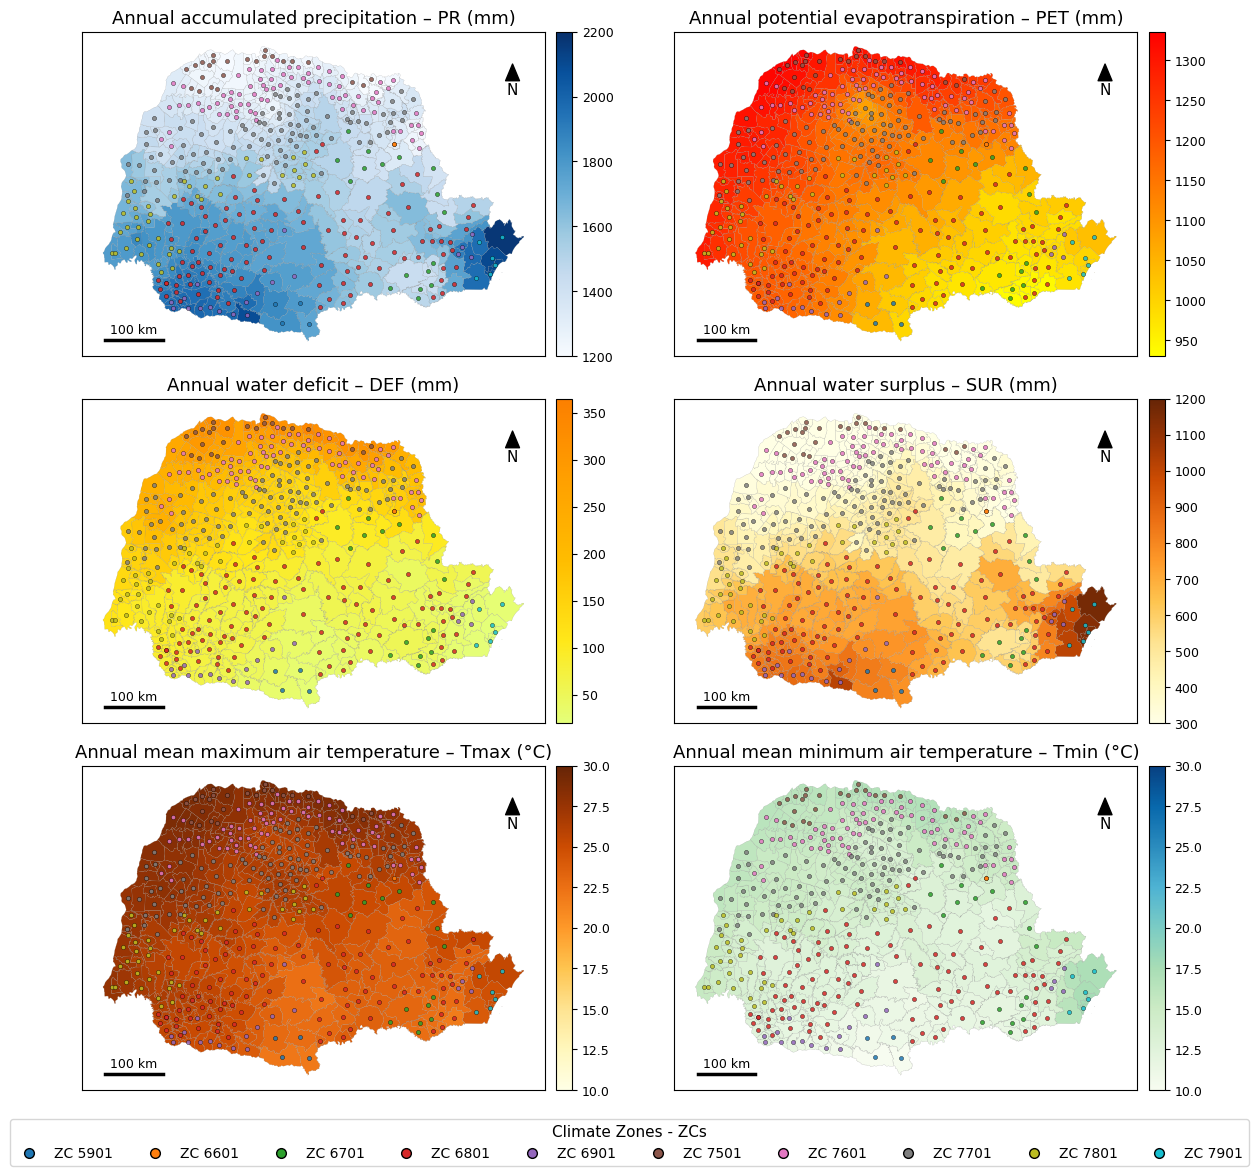

In [10]:

# =========================================================
# DATA INPUT
# =========================================================
# Load concatenated climatic dataset (continuous variables + climate zones)
url = "https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/dados_concatenados_zc.csv"
df = pd.read_csv(url, sep=",")


# =========================================================
# CLIMATIC MULTIPLOT – PARANÁ STATE
# CONTINUOUS MAPS + CLIMATE ZONES
# =========================================================

# ---------------------------------------------------------
# SUPPRESS WARNINGS
# ---------------------------------------------------------
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# ---------------------------------------------------------
# AUXILIARY FUNCTIONS
# ---------------------------------------------------------
def fmt_factory(fmt):
    """
    Creates a formatter for colorbar tick labels.
    """
    return FuncFormatter(lambda x, pos: fmt % x)


def add_north_arrow(ax, x=0.93, y=0.9, size=0.08):
    """
    Adds a north arrow to the map.
    Coordinates are given in axes fraction units.
    """
    ax.annotate(
        'N',
        xy=(x, y),
        xytext=(x, y - size),
        arrowprops=dict(facecolor='black', width=3, headwidth=10),
        ha='center',
        va='center',
        fontsize=11,
        xycoords=ax.transAxes
    )


def add_scalebar(ax, length_km=100, loc=(0.05, 0.05), linewidth=2.5):
    """
    Adds an approximate scale bar (valid for Paraná latitude range).
    Conversion assumes 1° ≈ 111 km.
    """
    x0, y0 = loc
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    length_deg = length_km / 111.0  # Approximation for southern Brazil

    x_start = xlim[0] + x0 * (xlim[1] - xlim[0])
    y_start = ylim[0] + y0 * (ylim[1] - ylim[0])

    ax.plot(
        [x_start, x_start + length_deg],
        [y_start, y_start],
        color='black',
        linewidth=linewidth,
        zorder=20
    )

    ax.text(
        x_start + length_deg / 2,
        y_start + 0.01 * (ylim[1] - ylim[0]),
        f"{length_km} km",
        ha='center',
        va='bottom',
        fontsize=9
    )


# ---------------------------------------------------------
# VARIABLE SPECIFICATIONS
# ---------------------------------------------------------
VAR_SPECS = {

    # Annual accumulated precipitation
    'pr': dict(
        title="Annual accumulated precipitation – PR",
        unit="mm",
        cmap='Blues',
        vmin=1200,
        vmax=2200,
        fmt="%.0f"
    ),

    # Annual potential evapotranspiration
    'pet': dict(
        title="Annual potential evapotranspiration – PET",
        unit="mm",
        cmap='autumn_r',
        vmin=930,
        vmax=1336,
        fmt="%.0f"
    ),

    # Annual water deficit
    'def': dict(
        title="Annual water deficit – DEF",
        unit="mm",
        cmap='Wistia',
        vmin=20,
        vmax=365,
        fmt="%.0f"
    ),

    # Annual water surplus
    'ro': dict(
        title="Annual water surplus – SUR",
        unit="mm",
        cmap='YlOrBr',
        vmin=300,
        vmax=1200,
        fmt="%.0f"
    ),

    # Annual mean maximum air temperature
    'tmmx': dict(
        title="Annual mean maximum air temperature – Tmax",
        unit="°C",
        cmap='YlOrBr',
        vmin=10,
        vmax=30,
        fmt="%.1f"
    ),

    # Annual mean minimum air temperature
    'tmmn': dict(
        title="Annual mean minimum air temperature – Tmin",
        unit="°C",
        cmap='GnBu',
        vmin=10,
        vmax=30,
        fmt="%.1f"
    ),
}

vars_plot = list(VAR_SPECS.keys())


# ---------------------------------------------------------
# CLIMATE ZONE COLORS
# ---------------------------------------------------------
ZC_COLORS = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]


# ---------------------------------------------------------
# CLIMATE ZONES (SORTED ORDER)
# ---------------------------------------------------------
zonas = sorted(df['ZC'].dropna().unique(), key=lambda x: str(x))

if len(zonas) > len(ZC_COLORS):
    raise ValueError("Number of climate zones exceeds available color list.")

zona_color = {z: ZC_COLORS[i] for i, z in enumerate(zonas)}


# ---------------------------------------------------------
# PARANÁ MUNICIPALITIES (IBGE – geobr)
# ---------------------------------------------------------
mun_pr = read_municipality(code_muni="PR", year=2020)

# Standardize municipality names for merging
mun_pr['municipio'] = (
    mun_pr['name_muni']
    .str.upper()
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
)


# ---------------------------------------------------------
# FIGURE LAYOUT
# ---------------------------------------------------------
n_vars = len(vars_plot)
ncols = 2
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(12, 4 * nrows)
)

axes = axes.flatten()


# ---------------------------------------------------------
# MAIN LOOP – GENERATE EACH MAP
# ---------------------------------------------------------
for i, variavel in enumerate(vars_plot):

    ax = axes[i]
    spec = VAR_SPECS[variavel]

    # Filter variable
    df_var = df[df['variavel'] == variavel].copy()

    # Standardize municipality names
    df_var['municipio'] = (
        df_var['municipio']
        .str.upper()
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
    )

    # Merge spatial + climatic data
    gdf_pr = mun_pr.merge(df_var, on='municipio', how='left')

    # --- CONTINUOUS MAP
    gdf_pr.plot(
        column='valor',
        cmap=spec['cmap'],
        vmin=spec['vmin'],
        vmax=spec['vmax'],
        linewidth=0.10,
        edgecolor='0.5',
        ax=ax
    )

    # --- COLORBAR
    norm = colors.Normalize(vmin=spec['vmin'], vmax=spec['vmax'])
    sm = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(spec['cmap']))
    sm.set_array([])

    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.08,
        pad=0.02,
        shrink=1.0,
        format=fmt_factory(spec['fmt'])
    )
    cbar.ax.tick_params(labelsize=9)

    # --- COMPUTE CENTROIDS (PROJECTED CRS FOR ACCURACY)
    gdf_pr = gdf_pr.to_crs(epsg=5880)
    gdf_pr['centroid'] = gdf_pr.geometry.centroid
    gdf_pr = gdf_pr.to_crs(epsg=4674)

    # --- PLOT CLIMATE ZONE POINTS
    for z in zonas:
        sub = gdf_pr[gdf_pr['ZC'] == z]
        if sub.empty:
            continue

        ax.scatter(
            sub.centroid.x,
            sub.centroid.y,
            s=9,
            color=zona_color[z],
            edgecolor='black',
            linewidth=0.3,
            alpha=0.85,
            zorder=10
        )

    # --- CARTOGRAPHIC ELEMENTS
    add_scalebar(ax, length_km=100)
    add_north_arrow(ax)

    ax.set_title(f"{spec['title']} ({spec['unit']})", fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])


# ---------------------------------------------------------
# REMOVE EMPTY SUBPLOTS
# ---------------------------------------------------------
for j in range(i + 1, len(axes)):
    axes[j].axis('off')


# ---------------------------------------------------------
# SINGLE LEGEND FOR CLIMATE ZONES
# ---------------------------------------------------------
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='none',
        label=f'ZC {z}',
        markerfacecolor=zona_color[z],
        markeredgecolor='black',
        markersize=7
    )
    for z in zonas
]

fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=len(zonas),
    frameon=True,
    title='Climate Zones - ZCs',
    title_fontsize=11,
    fontsize=10,
    bbox_to_anchor=(0.5, 0.02)
)

plt.tight_layout(rect=[0, 0.07, 1, 1])

# ---------------------------------------------------------
# EXPORT
# ---------------------------------------------------------
# plt.savefig("Figure2.png", dpi=600, bbox_inches='tight')

plt.show()


#BoxPlot by ZC

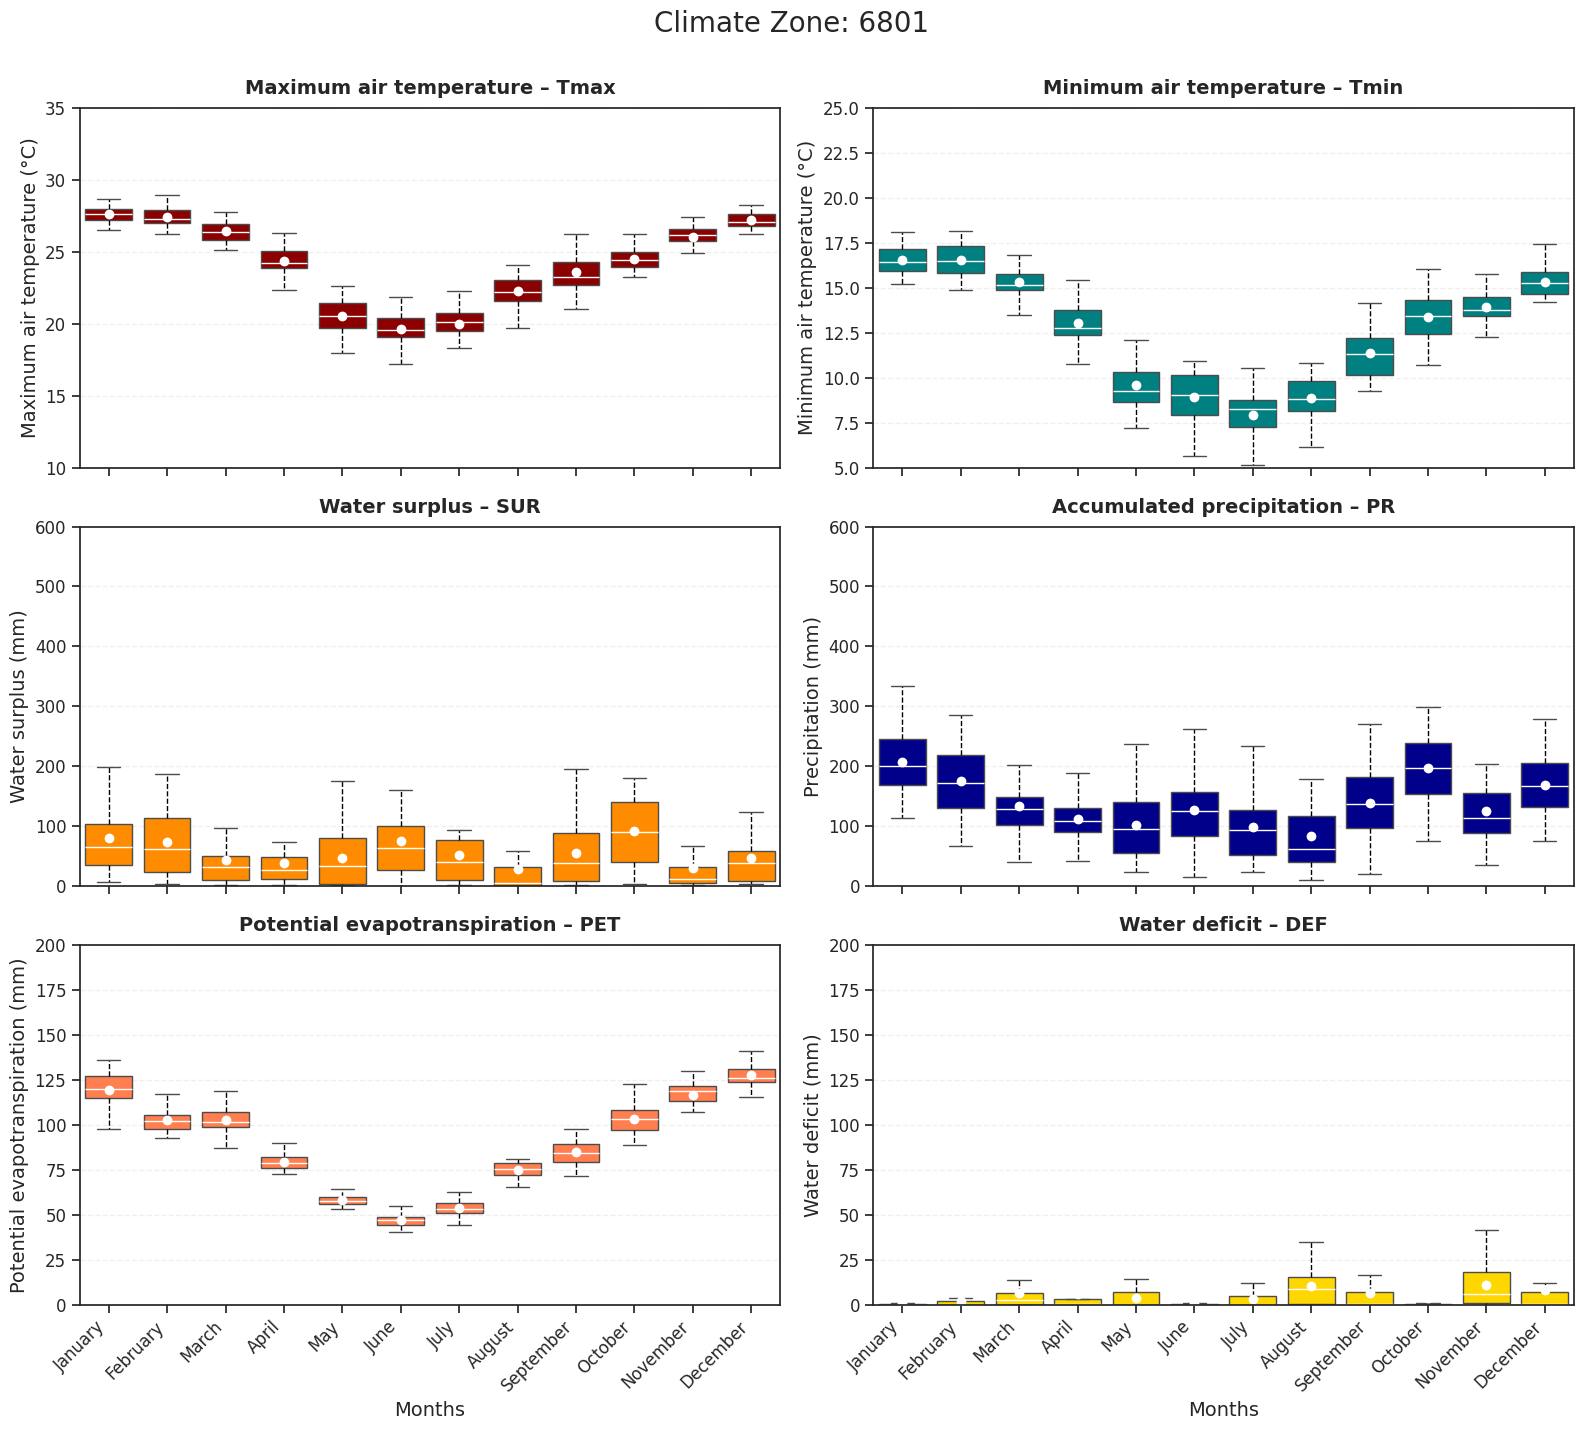

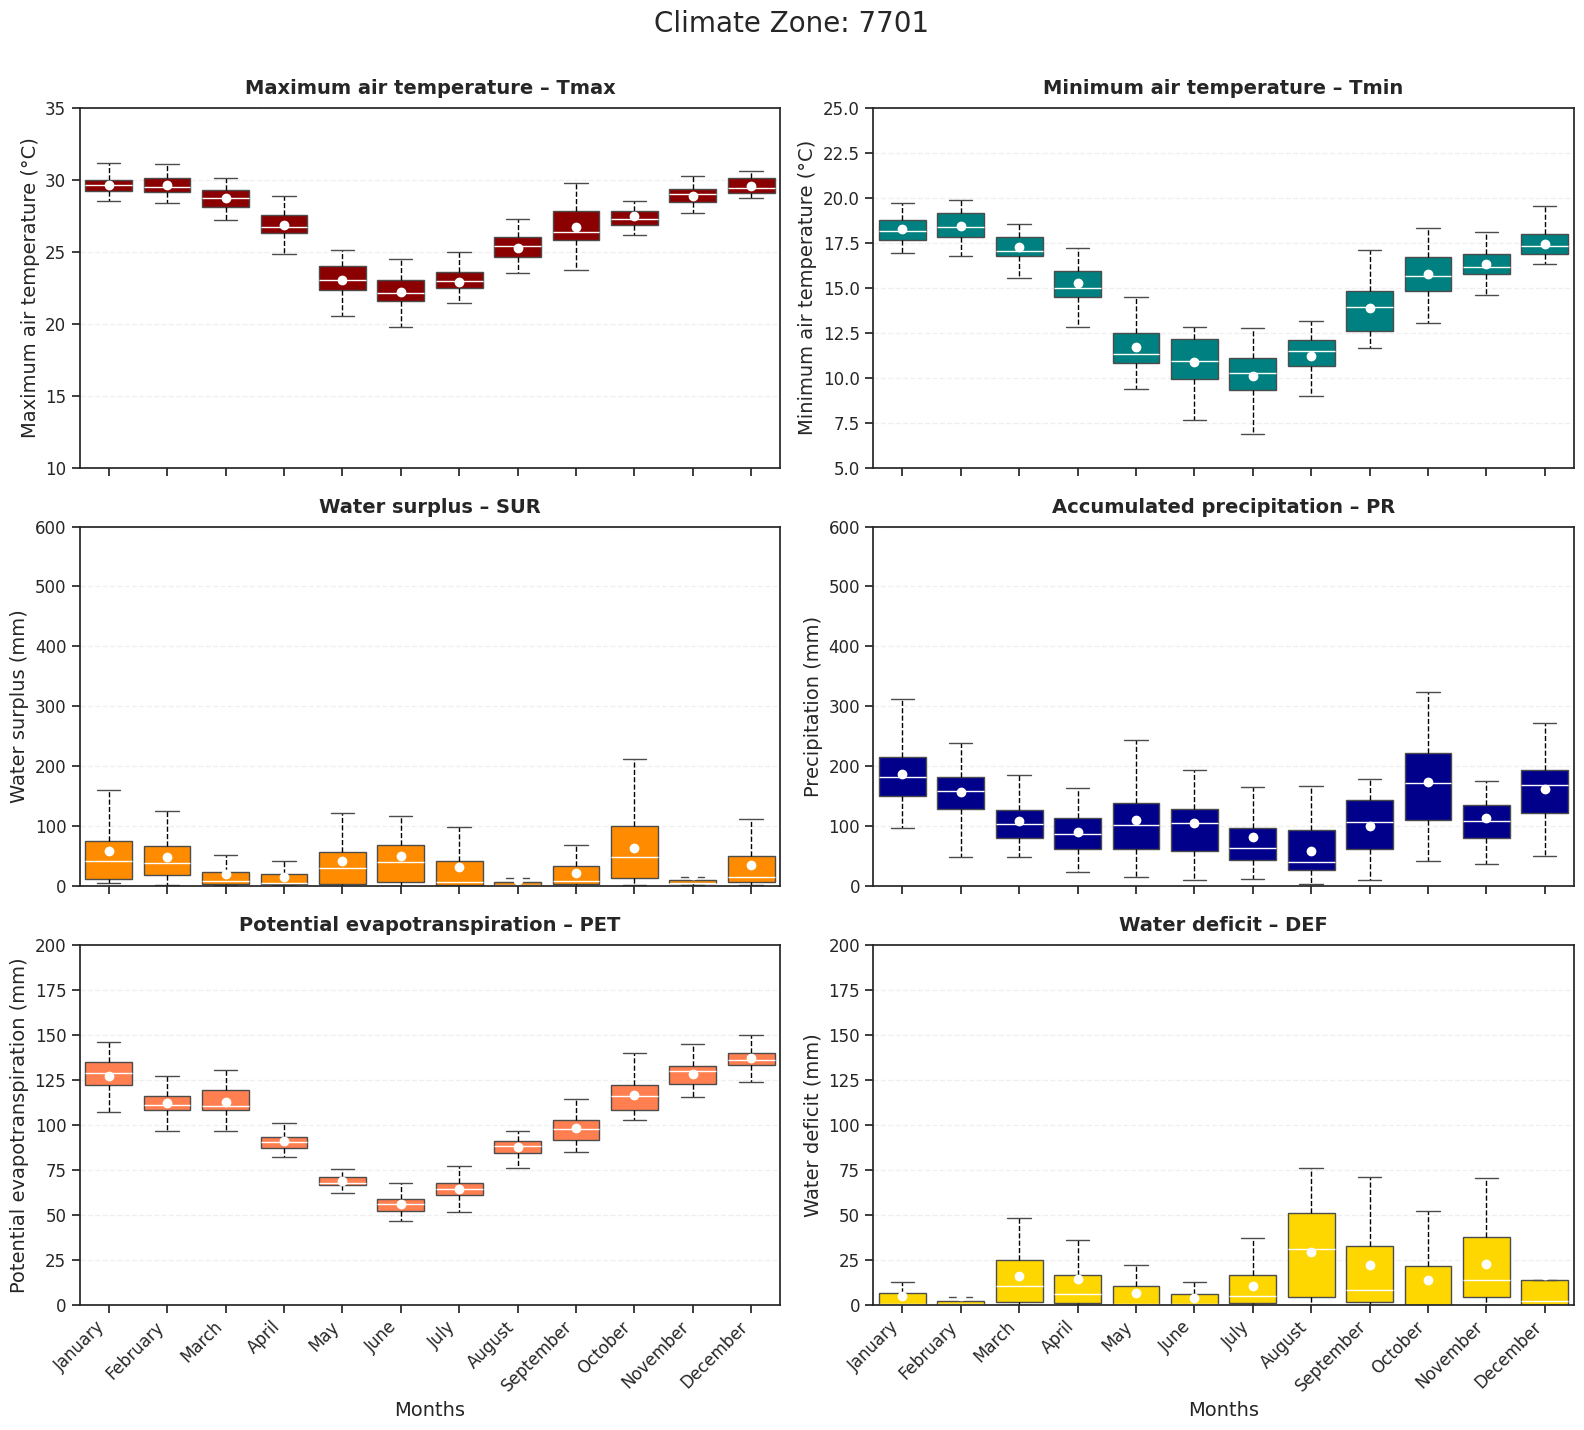

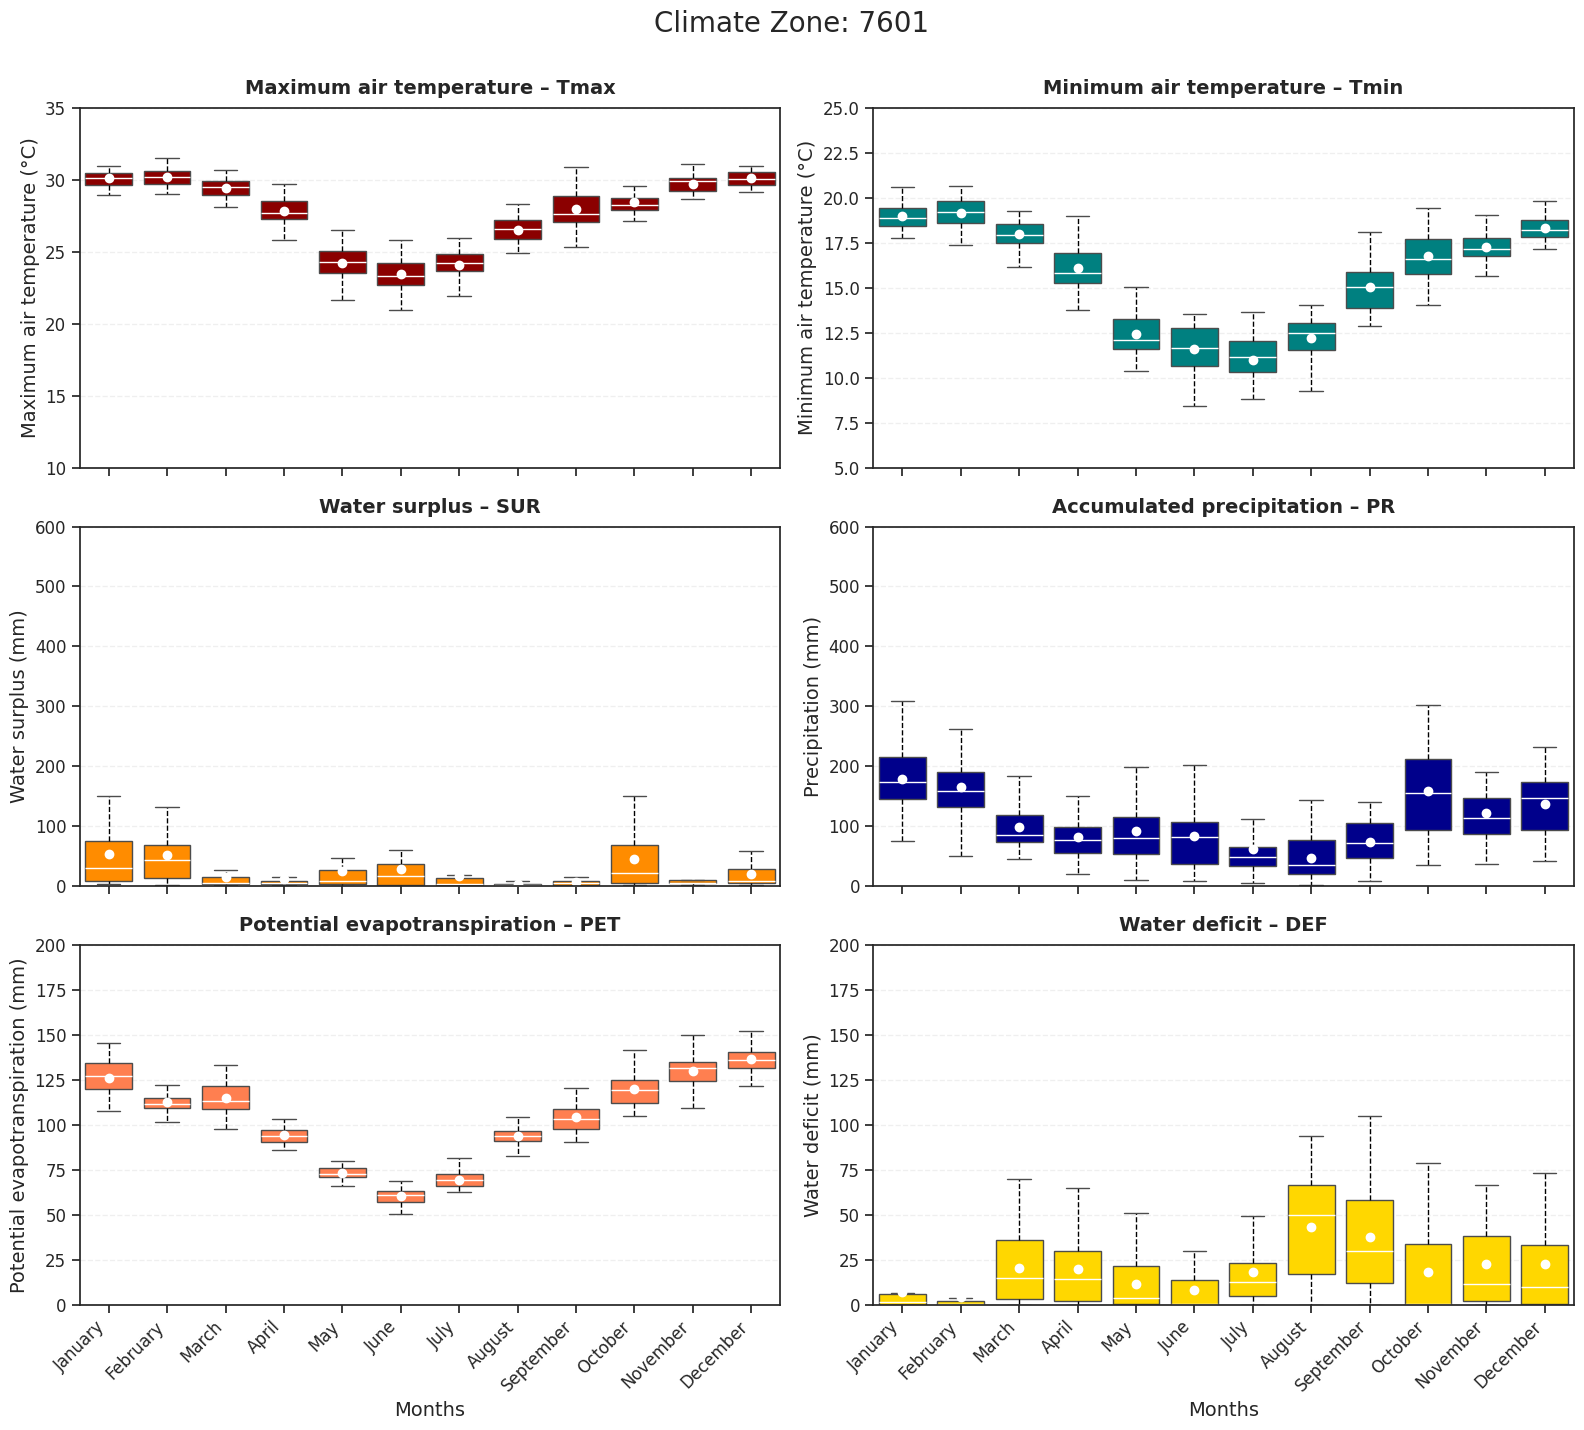

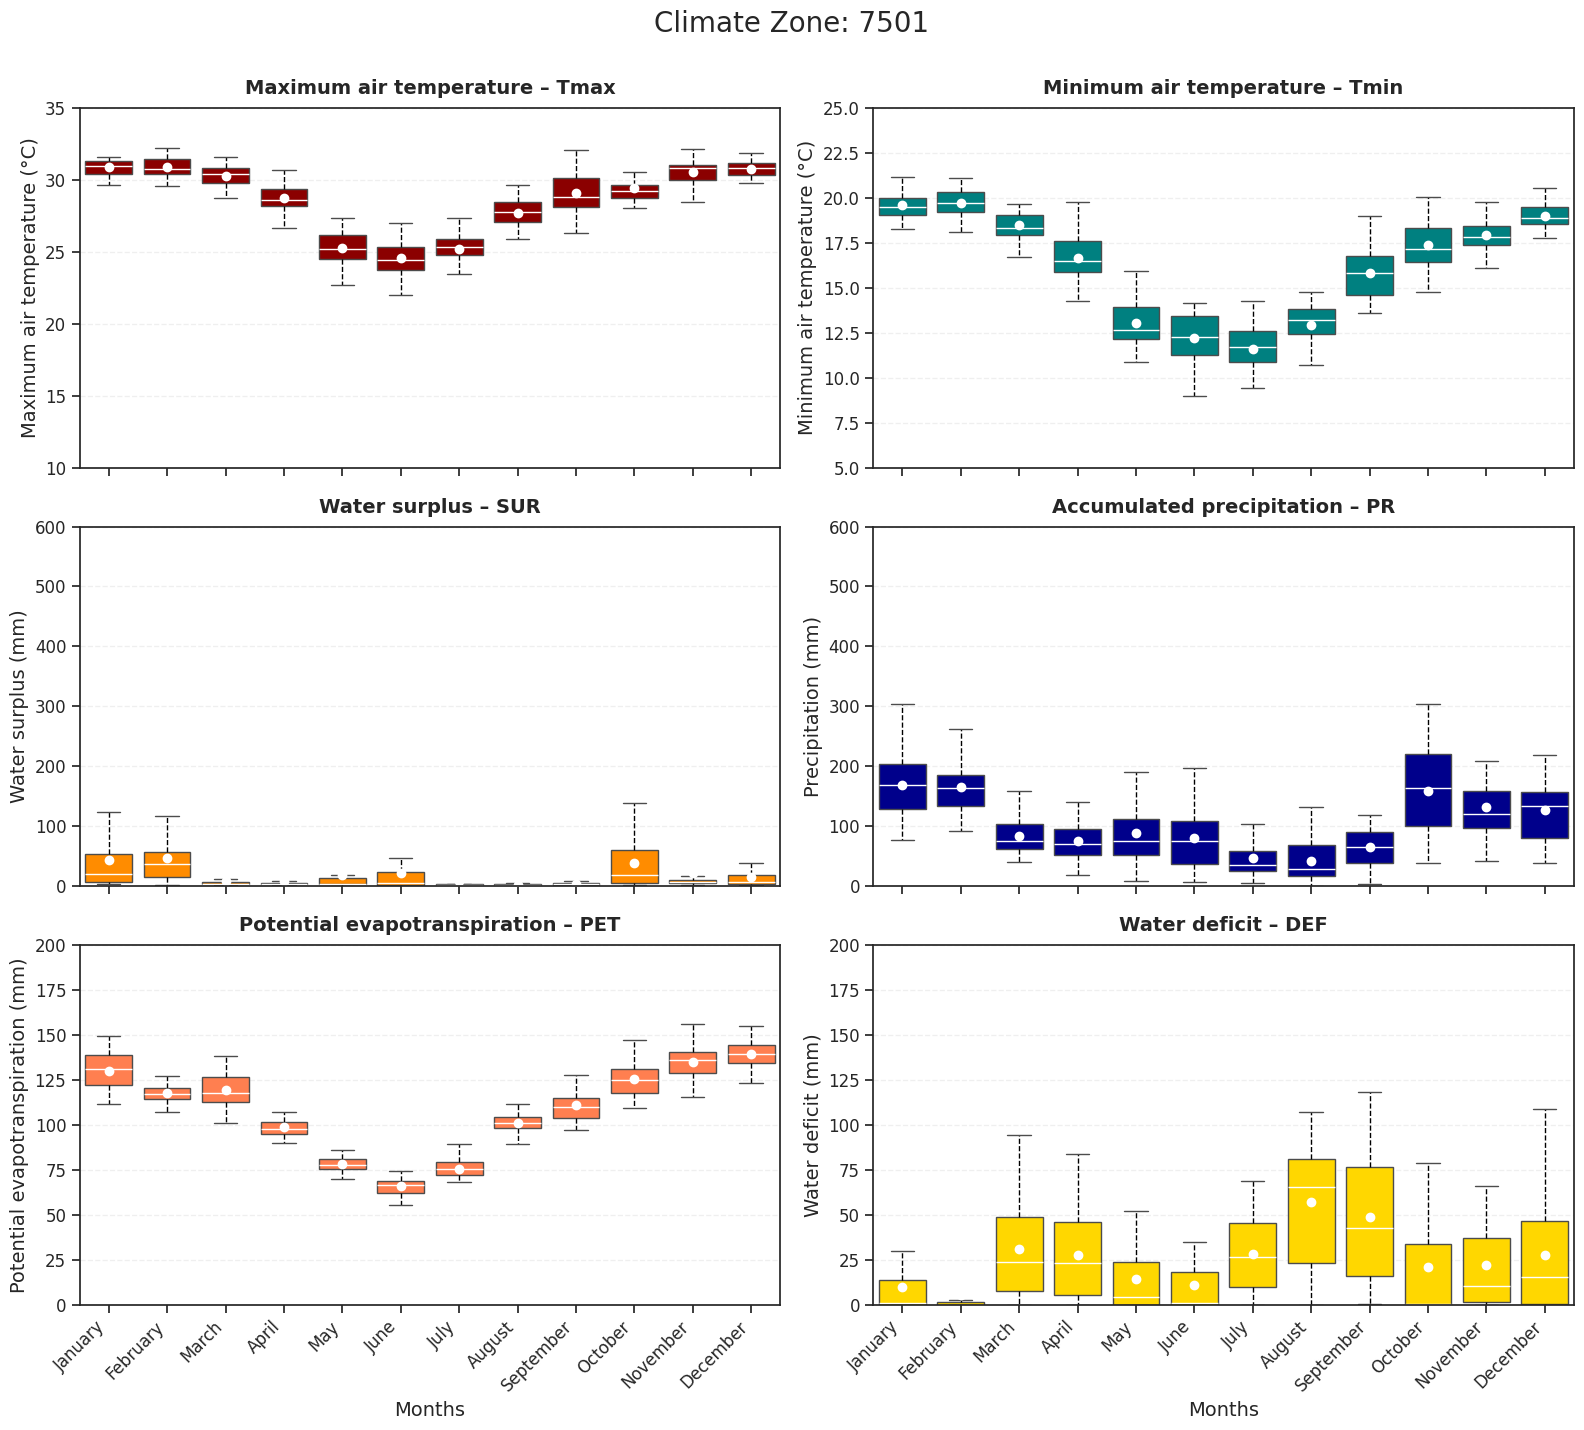

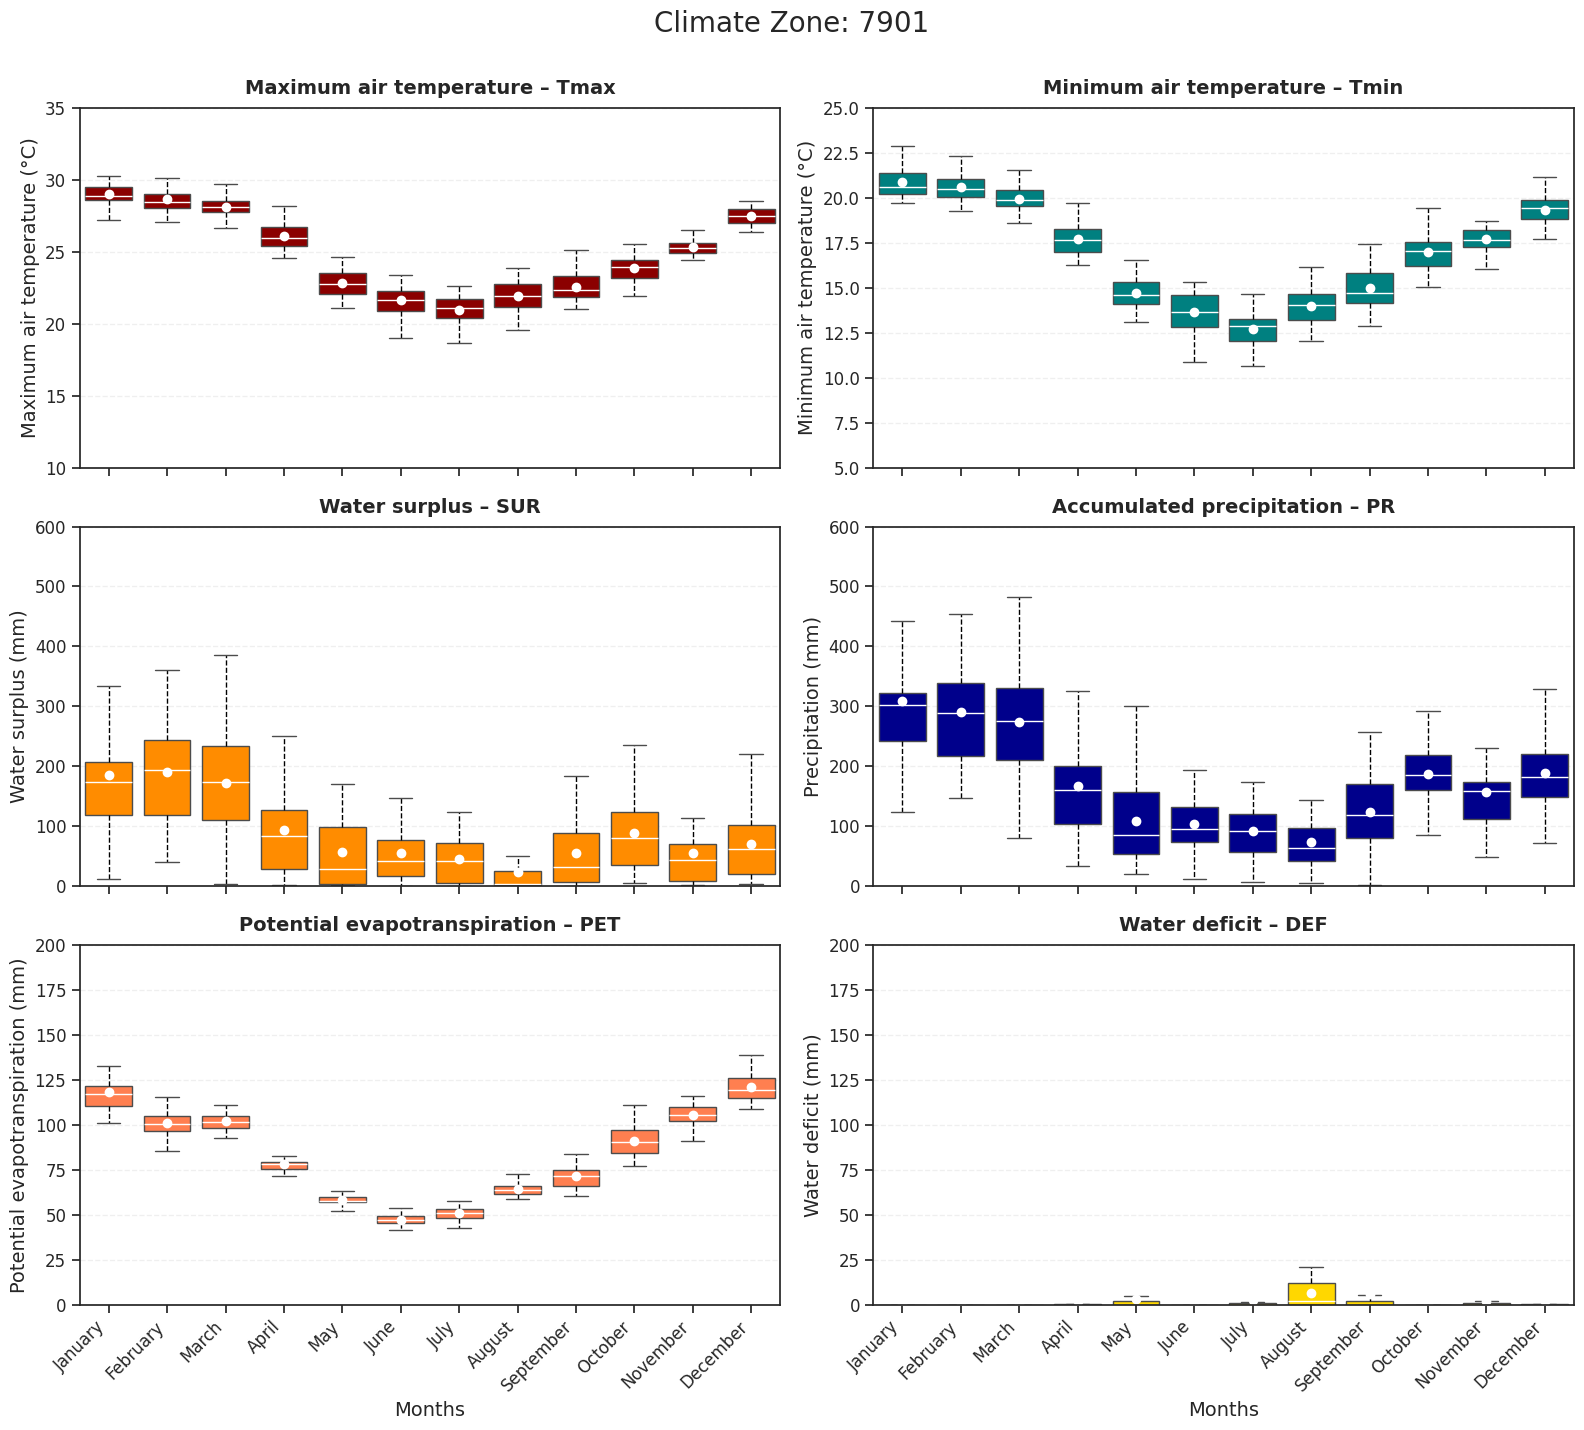

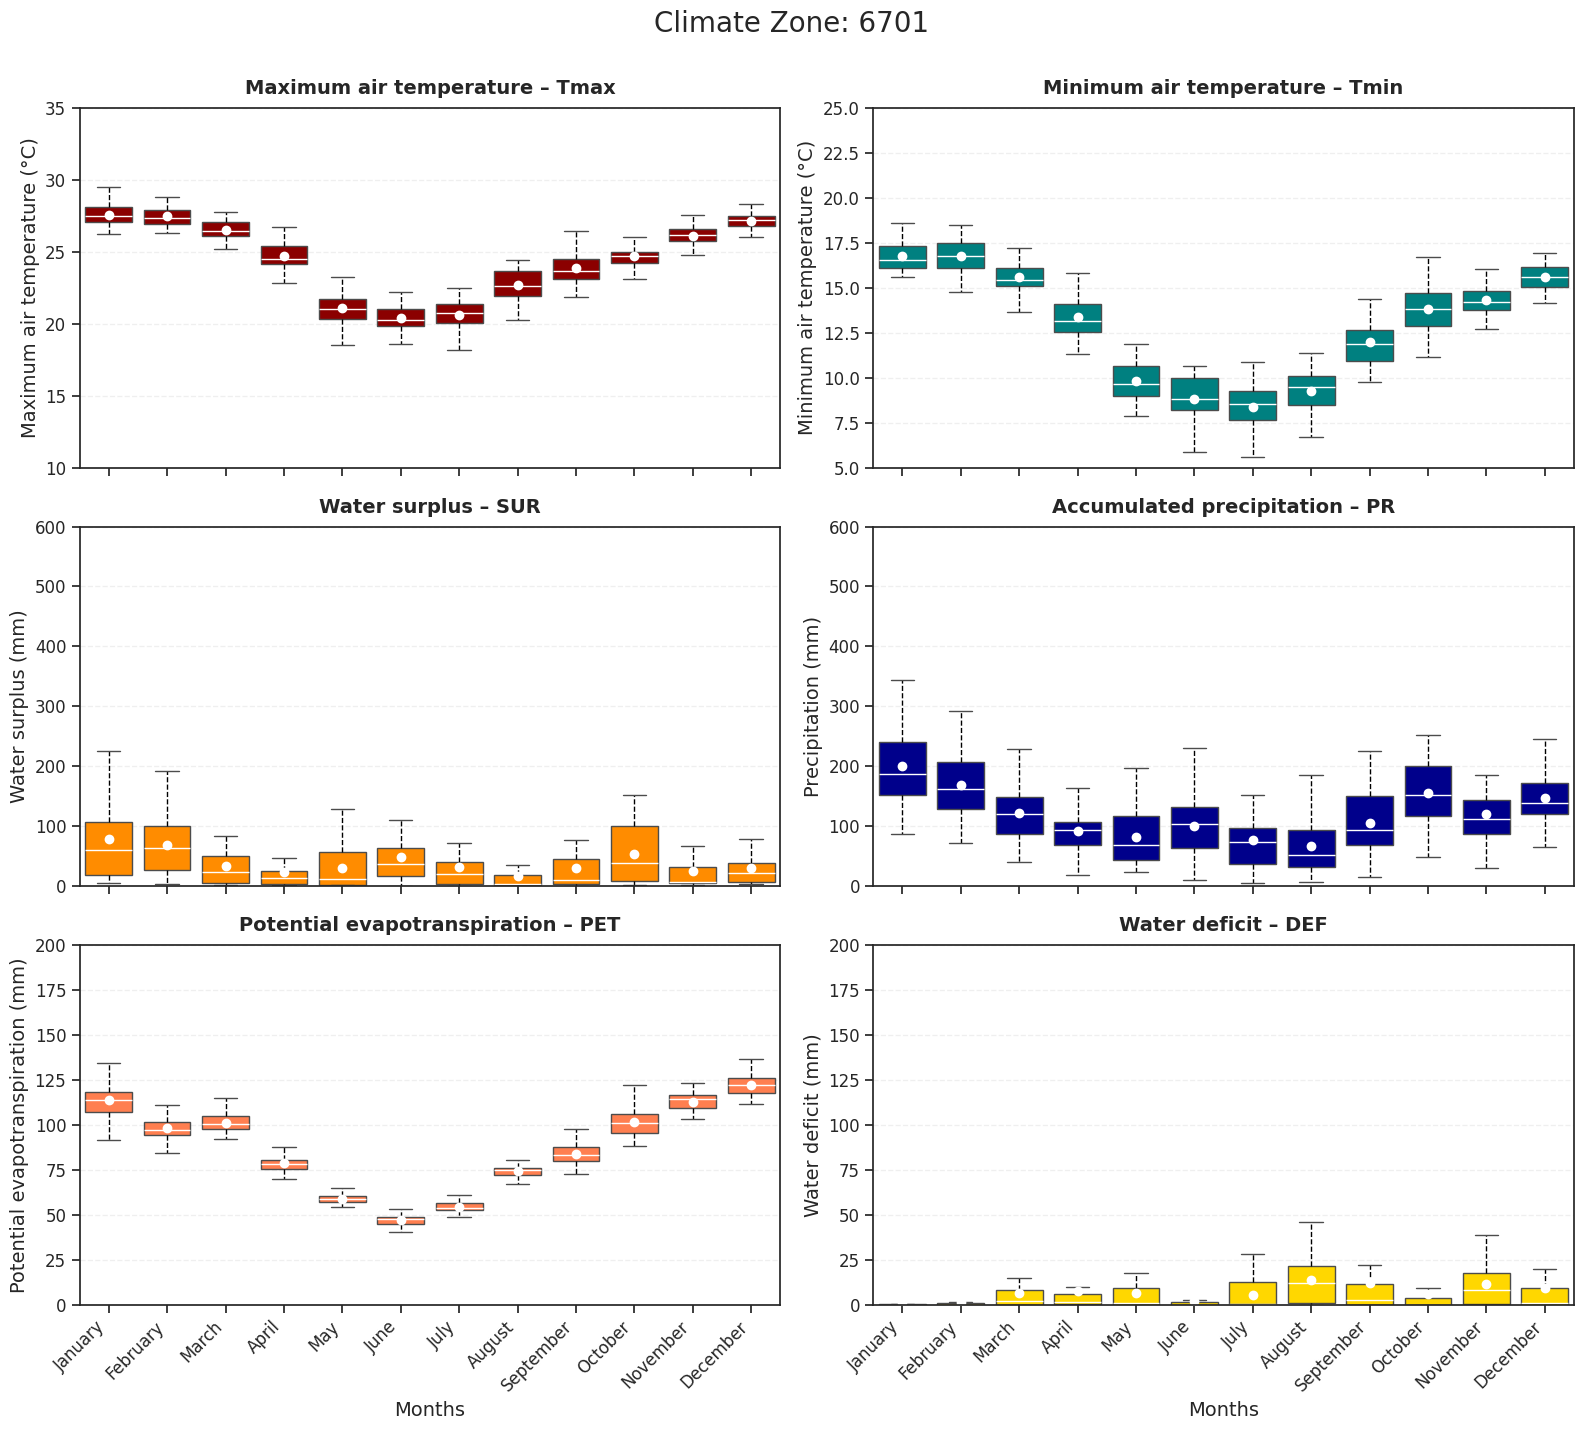

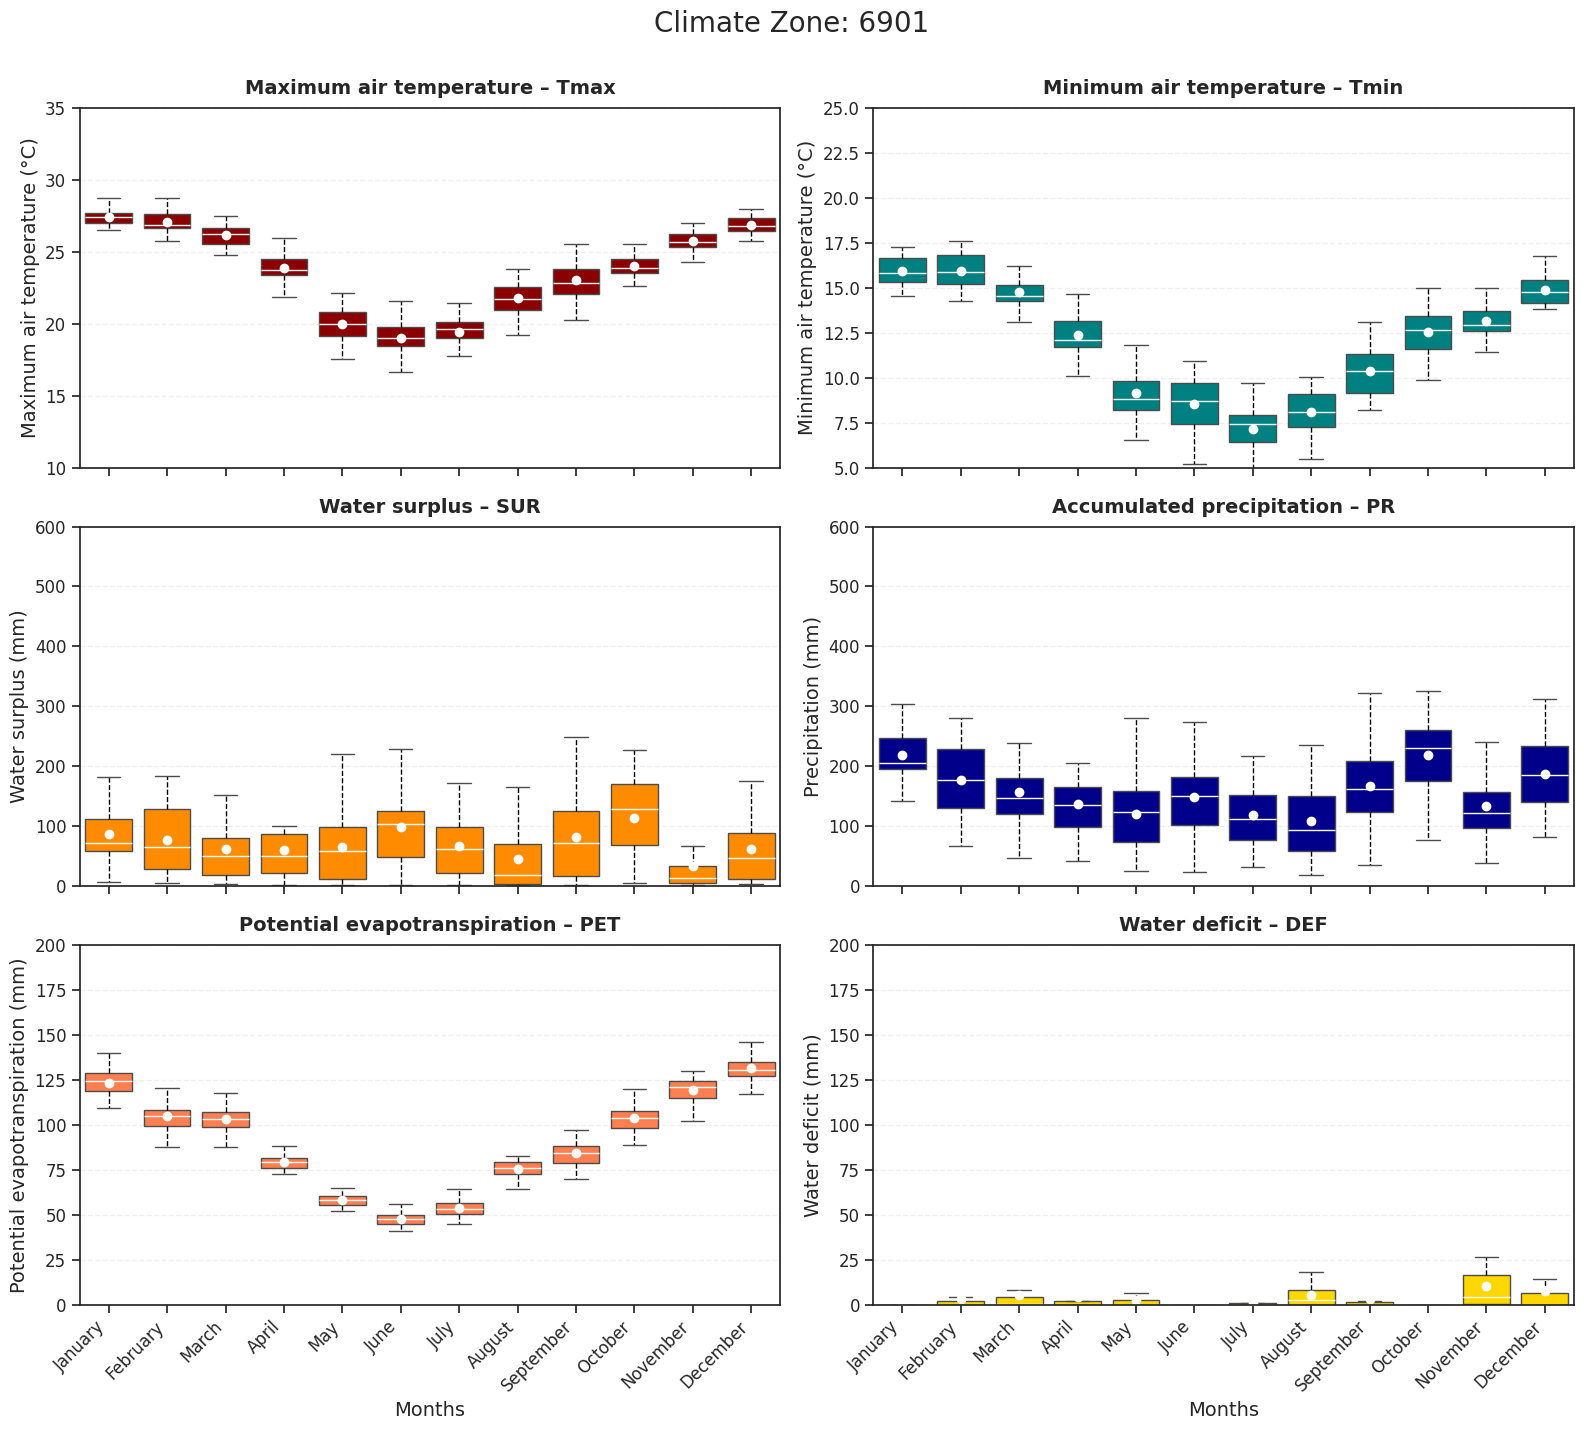

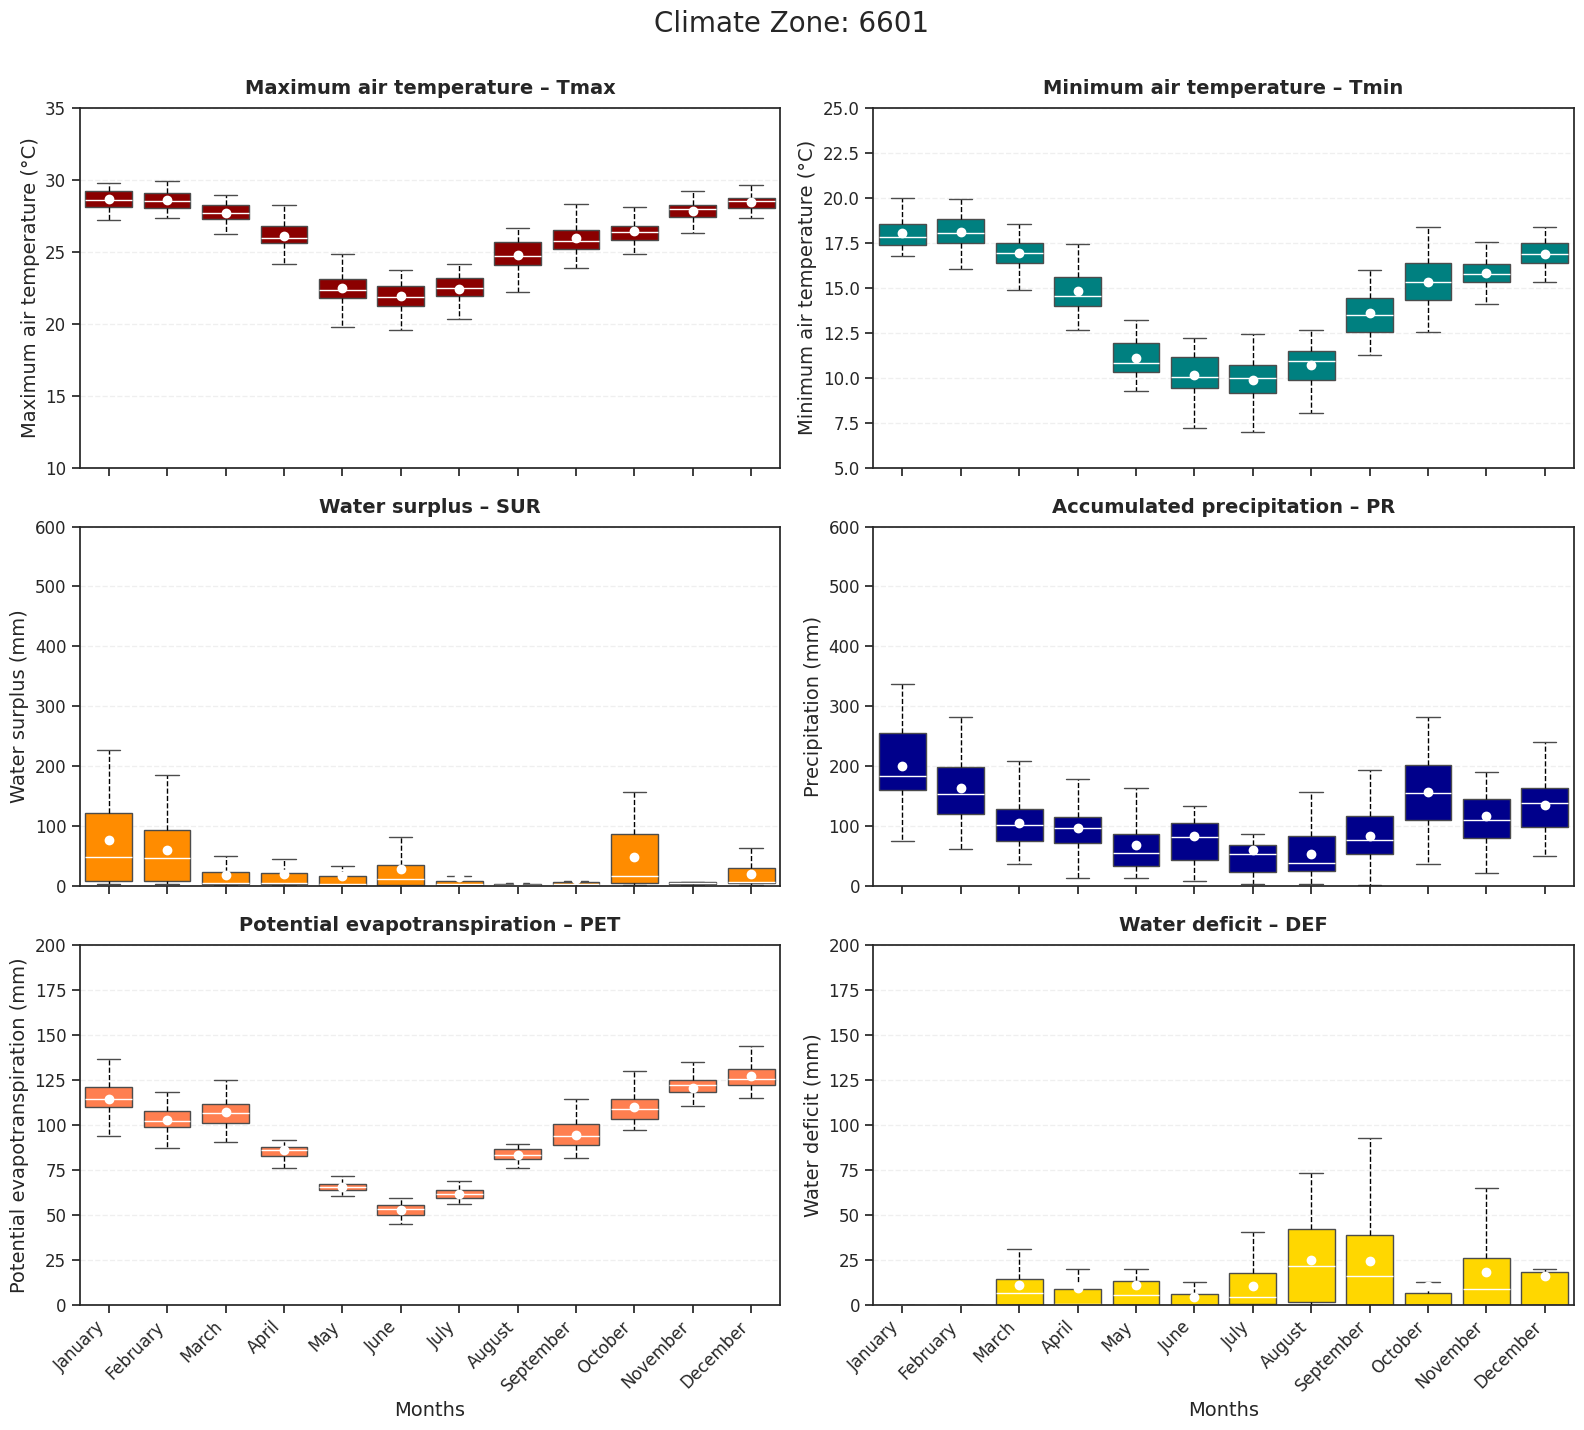

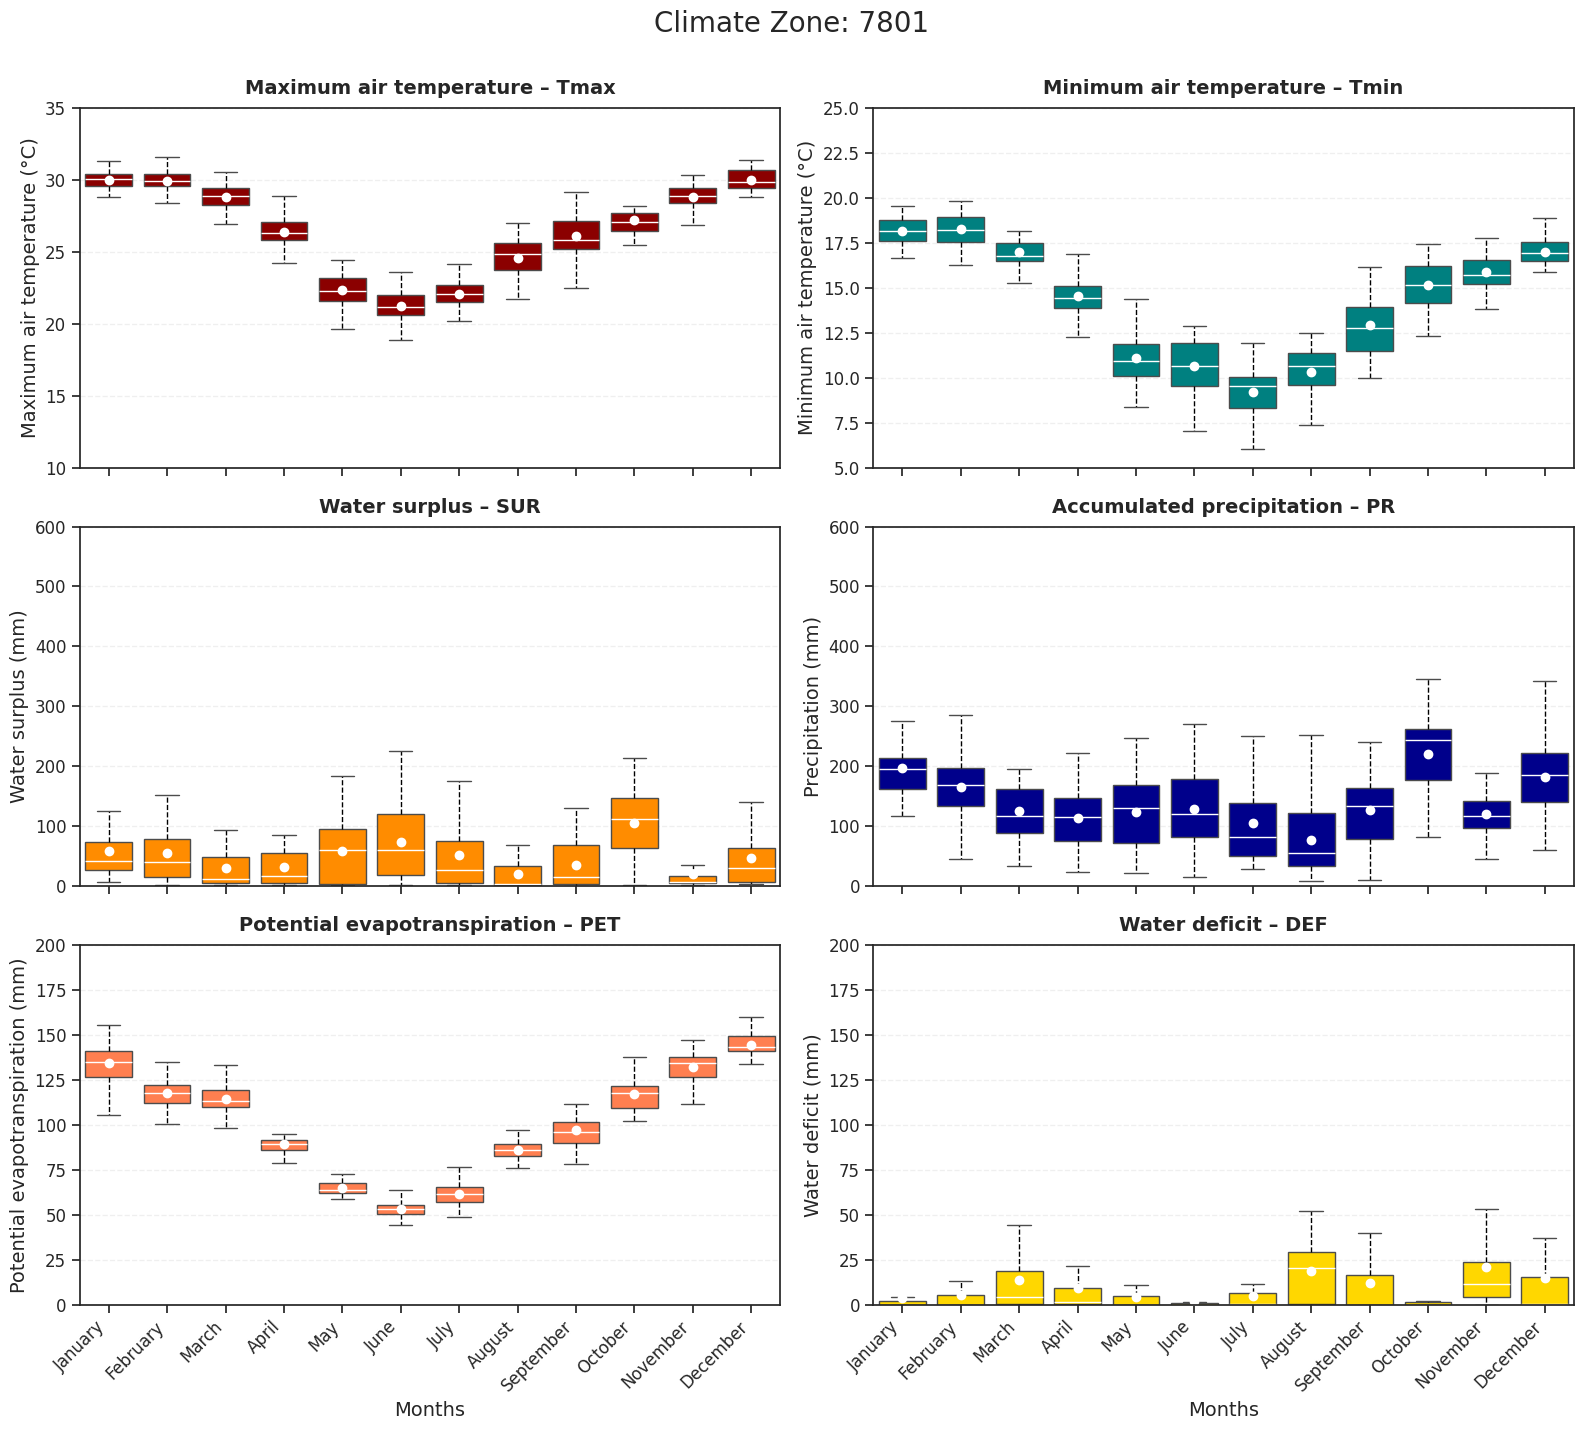

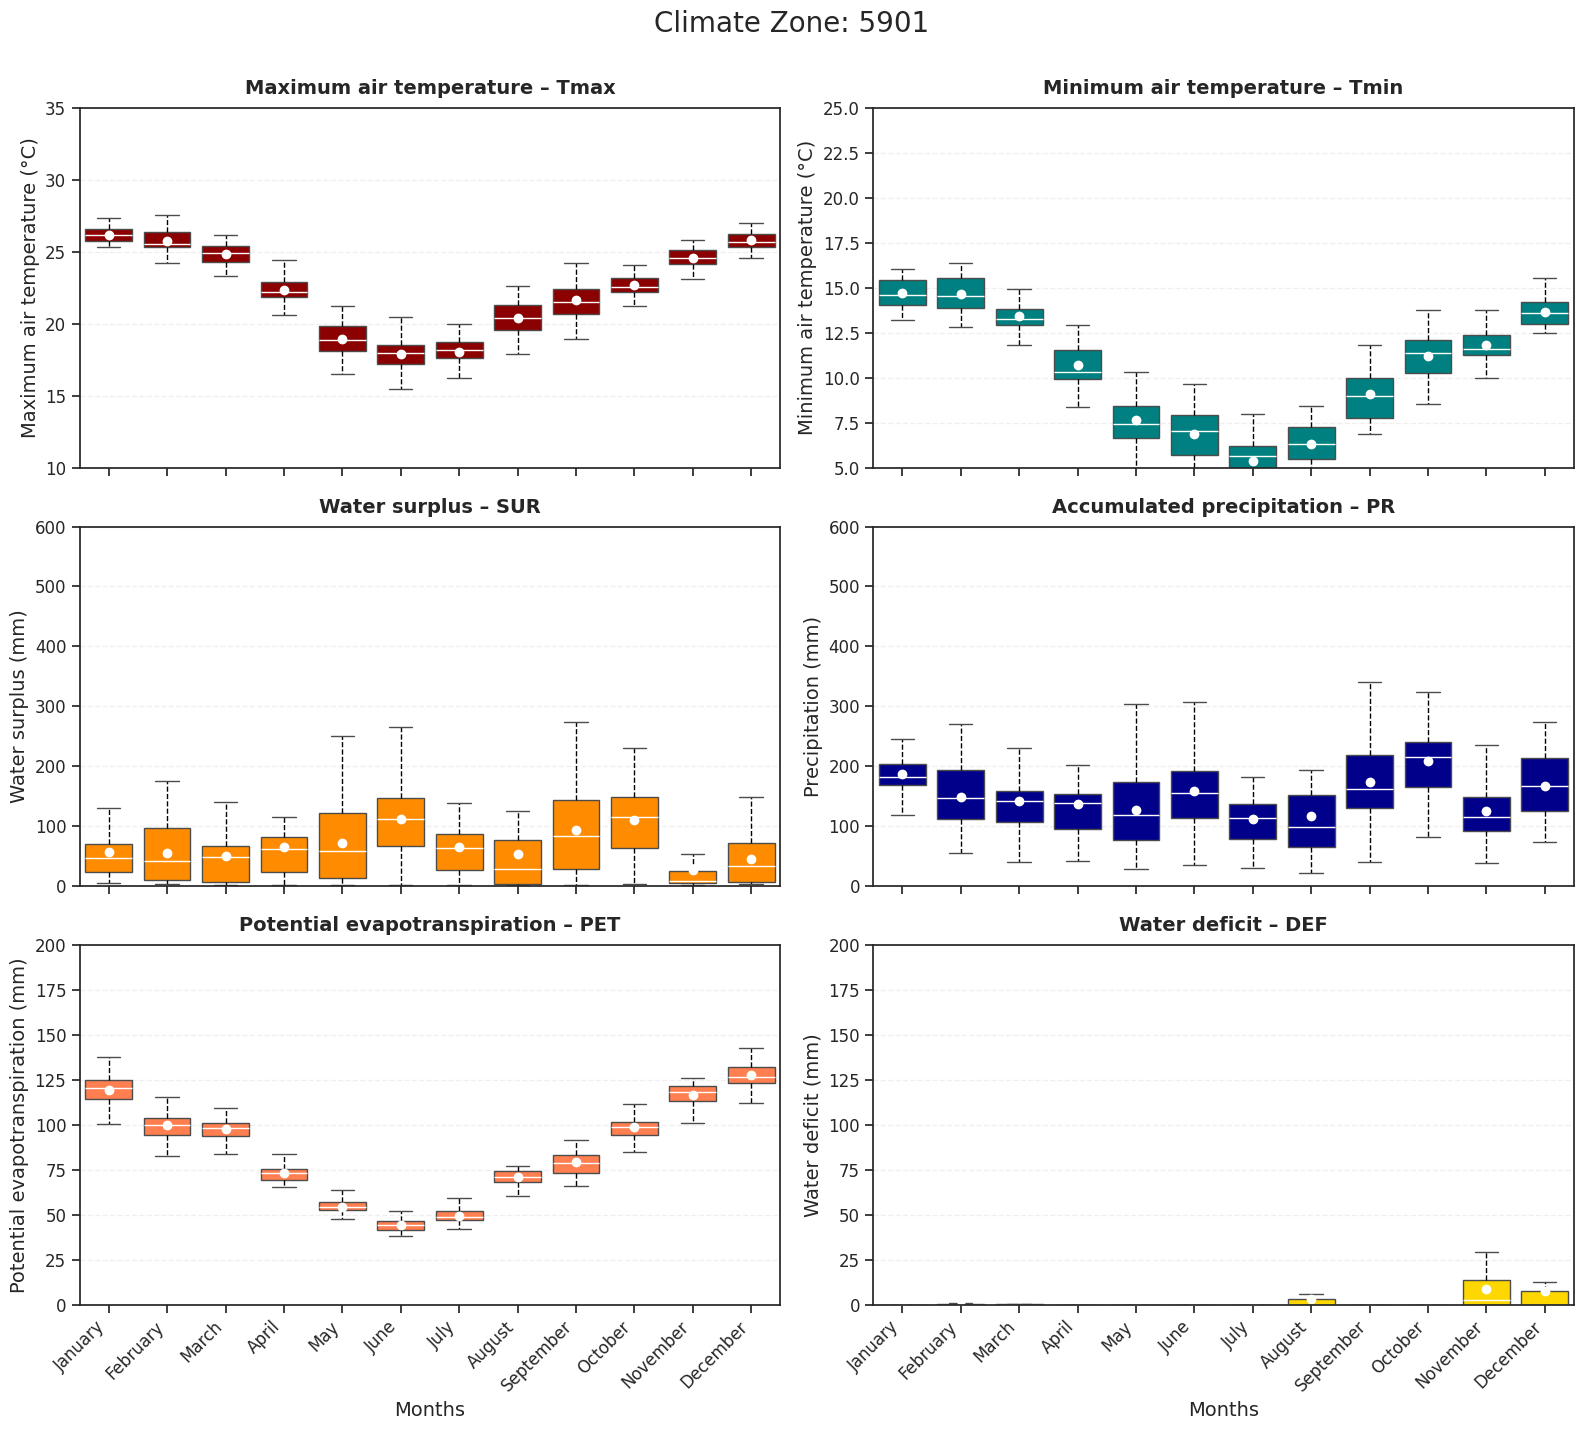

In [15]:

# List of spreadsheet IDs
numeros_planilhas = [6801, 7701, 7601, 7501, 7901, 6701, 6901, 6601, 7801, 5901]


# =========================================================
# LOOP THROUGH EACH CLIMATE ZONE FILE
# =========================================================
for planilha in numeros_planilhas:

    # Convert numeric ID to string to build file name
    nome_da_planilha = str(planilha)

    # Load CSV directly from GitHub
    url = f"https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/{nome_da_planilha}.csv"
    df = pd.read_csv(url)

    # Store variable column temporarily
    variavel = df['variavel']

    # Remove variable column for numeric conversion
    df = df.drop(columns=['variavel'])

    # Replace comma decimal separators with dot
    df = df.replace({',': '.'}, regex=True)

    # Convert all values to numeric
    df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1)

    # Restore variable column
    df['variavel'] = variavel

    # Climate zone identifier
    zona = planilha

    # -----------------------------------------------------
    # List of variables to be plotted
    # -----------------------------------------------------
    variaveis = ['def', 'pet', 'pr', 'ro', 'tmmn', 'tmmx']

    # Create separate DataFrames for each variable
    dfs = {}
    for variavel in variaveis:
        df_filtrado = df[df['variavel'] == variavel]
        df_filtrado = df_filtrado[['ano', 'mes', 'media', 'min', 'max', 'desvio']]
        dfs[variavel] = df_filtrado

    # -----------------------------------------------------
    # Seaborn configuration
    # -----------------------------------------------------
    sns.set()
    sns.set_style('ticks')

    # -----------------------------------------------------
    # Month labels (Portuguese → numeric mapping)
    # -----------------------------------------------------
    mes_labels = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]

    mes_map = {m: i + 1 for i, m in enumerate(mes_labels)}

    # -----------------------------------------------------
    # Variable limits dictionary (standardized axis range)
    # -----------------------------------------------------
    LIMITES_VARIAVEIS = {
        'tmmx': {"vmin": 10, "vmax": 35},   # Maximum temperature
        'tmmn': {"vmin": 5,  "vmax": 25},   # Minimum temperature
        'ro':   {"vmin": 0,  "vmax": 600},  # Water surplus
        'pr':   {"vmin": 0,  "vmax": 600},  # Precipitation
        'pet':  {"vmin": 0,  "vmax": 200},  # Potential evapotranspiration
        'def':  {"vmin": 0,  "vmax": 200},  # Water deficit
    }

    # -----------------------------------------------------
    # Helper functions
    # -----------------------------------------------------
    def _coerce_month_col(df, col='mes'):
        """
        Converts month column to numeric format if necessary.
        """
        s = df[col]
        if pd.api.types.is_numeric_dtype(s):
            m = s.astype(int)
        else:
            m = s.map(mes_map)
        return df.assign(_mes=m)

    def _order_present(d):
        """
        Returns sorted list of months present in the dataset.
        """
        present = sorted([int(x) for x in pd.unique(d['_mes'].dropna())])
        return present

    def _xticks_from_order(ax, order):
        """
        Configure x-axis ticks based on available months.
        """
        labels = [mes_labels[i - 1] for i in order]
        ax.set_xticks(range(len(order)))
        ax.set_xticklabels(labels, rotation=45, ha='right')

    def _box_mean(ax, df, facecolor, ylabel, vmin=None, vmax=None):
        """
        Creates boxplot with highlighted mean and custom axis limits.
        """

        # Convert month column
        d = _coerce_month_col(df).dropna(subset=['_mes', 'media'])

        # Order months
        ord_present = _order_present(d)

        # Define categorical order
        d = d.assign(
            _mes_cat=pd.Categorical(d['_mes'], categories=ord_present, ordered=True)
        )

        # Create boxplot
        sns.boxplot(
            data=d, x='_mes_cat', y='media',
            showcaps=True, showfliers=False,
            boxprops=dict(facecolor=facecolor),
            medianprops=dict(color='white', linewidth=1),
            whiskerprops=dict(color='black', linewidth=1, linestyle='dashed'),
            ax=ax
        )

        # Add mean points
        sns.pointplot(
            data=d, x='_mes_cat', y='media',
            estimator='mean', errorbar=None,
            markers="o", markersize=5,
            linestyles='',
            color='white', ax=ax
        )

        # Apply y-axis limits
        if vmin is not None and vmax is not None:
            ax.set_ylim(vmin, vmax)

        # Axis labels
        ax.set_xlabel("Months", fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)

        # X-axis formatting
        _xticks_from_order(ax, ord_present)

        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=12)

        # Add horizontal grid
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')


    # -----------------------------------------------------
    # Panel configuration
    # -----------------------------------------------------
    panels = [
        {
            "df": dfs['tmmx'],
            "color": "darkred",
            "ylabel": "Maximum air temperature (°C)",
            "title": "Maximum air temperature – Tmax",
            "vmin": LIMITES_VARIAVEIS['tmmx']['vmin'],
            "vmax": LIMITES_VARIAVEIS['tmmx']['vmax']
        },
        {
            "df": dfs['tmmn'],
            "color": "teal",
            "ylabel": "Minimum air temperature (°C)",
            "title": "Minimum air temperature – Tmin",
            "vmin": LIMITES_VARIAVEIS['tmmn']['vmin'],
            "vmax": LIMITES_VARIAVEIS['tmmn']['vmax']
        },
        {
            "df": dfs['ro'],
            "color": "darkorange",
            "ylabel": "Water surplus (mm)",
            "title": "Water surplus – SUR",
            "vmin": LIMITES_VARIAVEIS['ro']['vmin'],
            "vmax": LIMITES_VARIAVEIS['ro']['vmax']
        },
        {
            "df": dfs['pr'],
            "color": "darkblue",
            "ylabel": "Precipitation (mm)",
            "title": "Accumulated precipitation – PR",
            "vmin": LIMITES_VARIAVEIS['pr']['vmin'],
            "vmax": LIMITES_VARIAVEIS['pr']['vmax']
        },
        {
            "df": dfs['pet'],
            "color": "coral",
            "ylabel": "Potential evapotranspiration (mm)",
            "title": "Potential evapotranspiration – PET",
            "vmin": LIMITES_VARIAVEIS['pet']['vmin'],
            "vmax": LIMITES_VARIAVEIS['pet']['vmax']
        },
        {
            "df": dfs['def'],
            "color": "gold",
            "ylabel": "Water deficit (mm)",
            "title": "Water deficit – DEF",
            "vmin": LIMITES_VARIAVEIS['def']['vmin'],
            "vmax": LIMITES_VARIAVEIS['def']['vmax']
        },
    ]


    # -----------------------------------------------------
    # Create 3x2 figure layout
    # -----------------------------------------------------
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    axes_flat = axes.ravel()

    # Generate each subplot
    for ax, cfg in zip(axes_flat, panels):
        _box_mean(
            ax, cfg["df"], cfg["color"], cfg["ylabel"],
            vmin=cfg["vmin"], vmax=cfg["vmax"]
        )
        ax.set_title(cfg["title"], fontsize=14, fontweight='bold', pad=10)

    # Hide month labels for first two rows
    for i in range(2):
        for j in range(2):
            ax = axes[i, j]
            ax.tick_params(axis='x', labelbottom=False)
            ax.set_xlabel("")

    # Show month labels only in last row
    for j in range(2):
        ax = axes[2, j]
        ax.tick_params(axis='x', labelbottom=True)
        ax.set_xlabel("Months", fontsize=14)

    # Global figure title
    fig.suptitle(f'Climate Zone: {zona}', fontsize=20, y=1.02)

    # Layout adjustment
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)

    # Display figure
    plt.show()

    # Save figure (optional)
    fig.savefig(
        f'climate_analysis_zone_{zona}.png',
        dpi=300,
        bbox_inches='tight'
    )

    # Close figure to free memory
    plt.close(fig)


#Analysis of the ZCs
---

In [17]:
url = "https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/dados_concatenados_zc.csv"
df = pd.read_csv(url, sep = ",")

resultado = (
    df
    .groupby(['ZC', 'variavel'])['valor']
    .agg(['mean', 'std'])
    .unstack('variavel')
)
resultado

resultado.columns = [
    f'{var}_{stat}' for stat, var in resultado.columns
]

resultado = resultado.reset_index()

resultado

,ZC,def_mean,pet_mean,pr_mean,ro_mean,tmmn_mean,tmmx_mean,def_std,pet_std,pr_std,ro_std,tmmn_std,tmmx_std
0,5901,32.307809,1027.572833,1799.176621,803.085829,10.458622,22.414912,5.587111,28.765803,47.134148,24.348398,0.471511,0.471409
1,6601,139.288702,1122.242573,1315.443174,334.058025,14.141721,25.834764,4.391654,1.413138,11.893311,12.055734,0.052717,NaN
2,6701,76.640853,1029.586004,1435.114490,481.214203,12.719764,24.118362,31.204035,74.223380,43.752601,67.709384,0.789954,1.180774
3,6801,65.301483,1087.933679,1711.971350,688.645396,12.599154,24.380985,21.246359,84.436677,137.469748,93.310647,0.707229,1.159792
4,6901,52.141434,1107.771204,1928.524269,872.583468,12.069181,24.108070,17.113930,76.941063,87.642753,76.391832,1.208979,0.950446
5,7501,308.842164,1300.264259,1227.211355,236.146553,16.307616,28.681586,25.788860,23.579486,27.789655,19.114700,0.375236,0.269955
6,7601,229.418138,1224.091089,1296.896825,302.260516,15.485108,27.559608,42.899048,54.249502,48.028431,31.399227,0.646809,0.762362
7,7701,159.633022,1186.662218,1442.097708,414.310280,14.602447,26.626299,29.003340,57.090190,84.648541,56.806299,0.657047,0.738926
8,7801,117.255449,1212.486376,1677.262115,581.317280,14.203582,26.527637,18.527245,45.259859,108.614400,78.760244,0.624872,0.630700
9,7901,24.031643,1000.477791,2067.184591,1090.274242,17.105864,24.777153,3.873904,20.956861,84.633295,77.305140,0.527617,0.492306


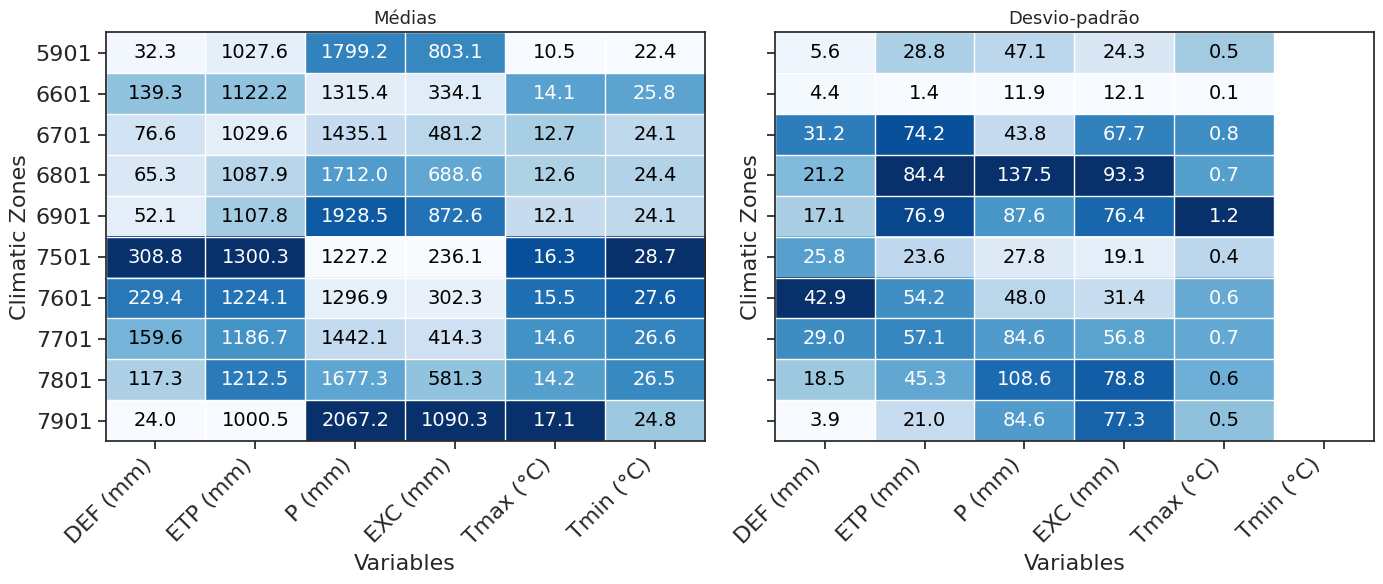

In [20]:
# --------- parâmetros básicos ---------
vars_base   = ["def", "pet", "pr", "ro", "tmmn", "tmmx"]
metrics     = ["mean", "std"]  # ordem dos painéis
titles      = {"mean": "Médias", "std": "Desvio-padrão"}

# --------- prepara matrizes por métrica ---------
df_sorted = resultado.set_index("ZC").sort_index()

# dicionário: métrica -> matriz (linhas = zonas, colunas = variáveis)
mats = {m: df_sorted[[f"{v}_{m}" for v in vars_base]] for m in metrics}
# --------- plota 1x2 ---------
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)

# Função para formatar com vírgula
def fmt_virgula(x, pos):
    """Formatador para usar vírgula como separador decimal"""
    return f"{x:.1f}".replace('.', '.')

for i, (ax, m) in enumerate(zip(axes.flatten(), metrics)):
    mat = mats[m].to_numpy()

    # Normalizar por coluna (cada variável)
    mat_normalized = np.zeros_like(mat)
    vmin_global = np.inf
    vmax_global = -np.inf

    for col in range(mat.shape[1]):
        col_data = mat[:, col]
        vmin_col = np.min(col_data)
        vmax_col = np.max(col_data)

        # Atualizar min/max global para a colorbar
        vmin_global = min(vmin_global, vmin_col)
        vmax_global = max(vmax_global, vmax_col)

        # Normalizar a coluna entre 0 e 1
        if vmax_col != vmin_col:
            mat_normalized[:, col] = (col_data - vmin_col) / (vmax_col - vmin_col)
        else:
            mat_normalized[:, col] = 0.5  # valor médio para colunas constantes

    # Aplicar a paleta Blues na matriz normalizada
    colors = plt.cm.Blues(mat_normalized)
    im = ax.imshow(colors, aspect="auto")
    ax.set_title(titles[m], fontsize=13)

    # ----------------------------
    # --- TEXTOS NO HEATMAP -----
    # ----------------------------
    for j in range(len(mats[m].index)):
        for k in range(len(vars_base)):

            # valor normalizado da célula (0 = mais escuro / 1 = mais claro)
            val_norm = mat_normalized[j, k]

            # cor do texto: branco para fundo escuro, preto para fundo claro
            text_color = "black" if val_norm < 0.5 else "white"

            ax.text(
                k, j,
                f"{mat[j, k]:.1f}".replace('.', '.'),
                ha="center",
                va="center",
                color=text_color,
                fontsize=14,
               # fontweight="bold",
            )

    # ticks e rótulos do eixo X (apenas na linha 1)
    if i >= 0:  # linha 1 (índices 2 e 3)
        ax.set_xticks(np.arange(len(vars_base)))
        ax.set_xticklabels(
            ["DEF (mm)", "ETP (mm)", "P (mm)", "EXC (mm)", "Tmax (°C)", "Tmin (°C)"],
            rotation=45, ha="right", fontsize=16
        )
        ax.set_ylabel("Climatic Zones", fontsize=16)
        ax.set_xlabel("Variables", fontsize=16)
    else:
        ax.set_xticks(np.arange(len(vars_base)))
        ax.set_xticklabels([])

    # ticks e rótulos do eixo Y
    ax.set_yticks(np.arange(len(mats[m].index)))
    ax.set_yticklabels(mats[m].index.astype(str), fontsize=16)

    # Adicionar linhas brancas delimitando as células
    for j in range(len(mats[m].index) + 1):
        ax.axhline(j - 0.5, color='white', linewidth=1)
    for k in range(len(vars_base) + 1):
        ax.axvline(k - 0.5, color='white', linewidth=1)

plt.tight_layout()
plt.show()

In [21]:
url = "https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/dados_concatenados_zc.csv"
df = pd.read_csv(url, sep = ",")

# Garante letras minúsculas
df['variavel'] = df['variavel'].str.lower()

# Pivot para formato largo
df_clima = (
    df.pivot_table(
        index=['estado', 'municipio', 'lat', 'lon', 'ZC'],
        columns='variavel',
        values='valor',
        aggfunc='mean'
    )
    .reset_index()
)

df_clima.head()

variavel,estado,municipio,lat,lon,ZC,def,pet,pr,ro,tmmn,tmmx
0,Parana,ABATIA,-23.311363,-50.306176,7601,210.718086,1206.659398,1307.379253,311.556630,15.127665,27.081352
1,Parana,ADRIANOPOLIS,-24.781986,-48.819381,6801,54.045608,1013.932958,1505.512165,544.547239,15.256973,25.303699
2,Parana,AGUDOS DO SUL,-26.025501,-49.309155,6801,33.173108,932.795928,1568.640344,668.200648,12.061930,21.940224
3,Parana,ALMIRANTE TAMANDARE,-25.284879,-49.322794,6801,35.327444,971.290520,1749.590688,812.798507,12.630313,22.602725
4,Parana,ALTAMIRA DO PARANA,-24.812720,-52.691907,6801,99.582733,1164.608342,1673.702794,607.913095,14.157846,25.949021


In [24]:
numeric_columns_to_agg = ['lat', 'lon', 'def', 'pet', 'pr', 'ro', 'tmmn', 'tmmx']

resultado = (
    df_clima
    .groupby(['ZC'])[numeric_columns_to_agg] # Select specific numeric columns for aggregation
    .agg(['mean', 'std'])
    # Removed .unstack('variavel') as it's not applicable to df_clima structure
)

resultado.columns = [
    f'{var}_{stat}' for var, stat in resultado.columns # Adjust to new MultiIndex column structure (var, stat)
]

resultado = resultado.reset_index()

resultado

,ZC,lat_mean,lat_std,lon_mean,lon_std,def_mean,def_std,pet_mean,pet_std,pr_mean,pr_std,ro_mean,ro_std,tmmn_mean,tmmn_std,tmmx_mean,tmmx_std
0,5901,-26.318340,0.165411,-51.663560,0.247342,32.307809,5.587111,1027.572833,28.765803,1799.176621,47.134148,803.085829,24.348398,10.458622,0.471511,22.414912,0.471409
1,6601,-23.926774,0.054768,-50.056742,0.040597,139.288702,4.391654,1122.242573,1.413138,1315.443174,11.893311,334.058025,12.055734,14.141721,0.052717,25.834764,NaN
2,6701,-24.917935,0.857449,-49.974995,0.550006,76.640853,31.204035,1029.586004,74.223380,1435.114490,43.752601,481.214203,67.709384,12.719764,0.789954,24.118362,1.180774
3,6801,-25.371783,0.509476,-51.627431,1.491452,65.301483,21.246359,1087.933679,84.436677,1711.971350,137.469748,688.645396,93.310647,12.599154,0.707229,24.380985,1.159792
4,6901,-25.925067,0.400691,-51.912971,1.675304,52.141434,17.113930,1107.771204,76.941063,1928.524269,87.642753,872.583468,76.391832,12.069181,1.208979,24.108070,0.950446
5,7501,-22.839976,0.178191,-52.340482,0.871188,308.842164,25.788860,1300.264259,23.579486,1227.211355,27.789655,236.146553,19.114700,16.307616,0.375236,28.681586,0.269955
6,7601,-23.249986,0.293820,-51.714312,1.144136,229.418138,42.899048,1224.091089,54.249502,1296.896825,48.028431,302.260516,31.399227,15.485108,0.646809,27.559608,0.762362
7,7701,-23.804916,0.375564,-52.100887,1.189271,159.633022,29.003340,1186.662218,57.090190,1442.097708,84.648541,414.310280,56.806299,14.602447,0.657047,26.626299,0.738926
8,7801,-24.830926,0.496191,-53.282218,0.991263,117.255449,18.527245,1212.486376,45.259859,1677.262115,108.614400,581.317280,78.760244,14.203582,0.624872,26.527637,0.630700
9,7901,-25.545502,0.246110,-48.574832,0.149491,24.031643,3.873904,1000.477791,20.956861,2067.184591,84.633295,1090.274242,77.305140,17.105864,0.527617,24.777153,0.492306
